# Implementing eigenmode extraction of thickness variation with ICA

---

Here we evaluate the thickness kernel decomposition computed by performing ICA over the complete set of high-resolution data


### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [3]:
# path setting
main_dir = os.path.abspath('../../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

### Brain visualization functions

---

In [4]:
from nilearn import datasets, surface, plotting
from matplotlib.colors import LinearSegmentedColormap


In [5]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{main_dir}/data/templates/ones.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
ax = np.concatenate([lx - expand, rx + expand])
ay = np.concatenate([ly, ry])
az = np.concatenate([lz, rz])
at = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
axyz = np.array([ax, ay, az]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


In [10]:
# arbitrary colormap
mycm = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.1, 0.1, 1.,)),
        # (0.4999, (0.9, 0.9, 1.,)),
        (0.25, (0.1, 1., 1.,)),
        # (0.4999, (0.9, 1., 1.,)),
        (0.5, (1., 1., 1.,)),
        # (0.5001, (1., 1., 0.9,)),
        (0.75, (1., 1., 0.1,)),
        # (0.5001, (1., 0.9, 0.9,)),
        (1.0, (1., 0.1, 0.1,)),
    )
)

mycm_dark = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.05, 1., 1.,)),
        (0.35, (0.05, 0.05, 1.,)),
        (0.5, (0.2, 0.05, 0.05,)),
        (0.65, (1., 0.05, 0.05,)),
        (1.0, (1., 1., 0.05,)),
    )
)

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

# load sulcal depth for background
sulcal_depth = nib.load(f"{main_dir}/data/templates/hcp_surf/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii")


# visualization via nilearn
def plot_data_on_brain_surface(data, title="", cmap=mycm, symmetric_cbar=True, vmax=None, vmin=None, background_data=sulcal_depth.get_fdata()[0], darkness=0.1, auto_vlim_quantile=0.05, colorbar_format=None):
    """
    Plot a cifti-like data over the fs-LR32k surface space.
    ----------------------------------------------------------------
    Parameters:
        - data: a vector of shape (59412,) to be visualized.
        - title: the title of generated plot.
        - cmap: the colormap used for the plot.
        - symmetric_cbar: bool, Specifies whether the 
          colorbar should be symmetric (centered at zero).
        - vmax: colorbar max limit.
        - vmin: colorbar min limit.
        - background data: a surface data to project as a shadow
          behind the main data. (use None for no background)
        - darkness: the background effect
        - auto_vlim_quantile: the quantile to define vmin and vmax
          automatically (should be in the range of [0,0.5)]).
        - colorbar_format: string format for numbers in colorbar.
    ----------------------------------------------------------------
    """
    # Initialization
    if vmax is None:
        vmax = np.quantile(data,1 - auto_vlim_quantile)
    if vmin is None:
        vmin = np.quantile(data,auto_vlim_quantile)
    if symmetric_cbar:
        (vmin, vmax) = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
    if background_data is not None:
        background = True
    else:
        background = False
    
    # surface center
    cxyz=(axyz.min(0) + axyz.max(0))/2

    # transfer data to surface scalar
    surface_scalars = np.empty(ax.shape[0])
    surface_scalars[:] = np.nan
    surface_scalars[surface_mask] = data.copy()

    # decompose left and right information
    left_surface_scalars = surface_scalars[:lx.shape[0]]
    right_surface_scalars = surface_scalars[-rx.shape[0]:]
    
    # Generate background data
    surface_background_data = np.zeros(ax.shape[0])
    surface_background_data[surface_mask] = background_data.copy()
    left_background_data = surface_background_data[:lx.shape[0]]
    right_background_data = surface_background_data[-rx.shape[0]:]


    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

    zoom_coeff = 0.85

    # 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[0,0],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
    axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
    axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[0,1],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
    axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
    axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[1,0],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
    axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
    axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[1,1],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
    axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
    axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

    fig.suptitle(title, fontsize=24, y=0.98);
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(
        axes[0,0],
        width="30%",
        height="4%",
        loc="center",
        bbox_to_anchor=(-0., 0.02, 1., 1.),
        bbox_transform=fig.transFigure,
        borderpad=0,
    )
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
            cmap=cmap
        ),
        cax=axins,
        aspect=10,
        orientation='horizontal',
        format=colorbar_format,
    )
    cb.outline.set_visible(False)
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(length=0)


## Load high-resolution thickness data

---

In [7]:
all_thickness_data = load_np(f'{main_dir}/data/npy/thickness_all_datasets.npy');


In [8]:
all_thickness_data.shape

(2473, 59412)

## Perform ICA to construct the kernel

---

In [9]:
%%time
from sklearn.decomposition import FastICA

# get all possible components
# thickness_ica = FastICA(n_components=all_thickness_data.shape[0], random_state=0, whiten='unit-variance')
thickness_ica = FastICA(n_components=1500, random_state=0, whiten='unit-variance')

thickness_ica.fit(all_thickness_data)


CPU times: user 27min 52s, sys: 13min 4s, total: 40min 57s
Wall time: 3min 36s


FastICA(n_components=1500, random_state=0, whiten='unit-variance')

In [46]:
# ensure correctness by checking the shape of all computed eigenmodes
thickness_ica.components_.shape


(1500, 59412)

In [47]:
# Check the proportion of explained variance
# np.sum(thickness_ica.explained_variance_ratio_)
np.var(thickness_ica.inverse_transform(thickness_ica.transform(all_thickness_data)))/ np.var(all_thickness_data)
# thickness_ica.inverse_transform(thickness_ica.transform(all_thickness_data)).shape


0.9371116163167038

In [48]:
# ensure correctness by validating that all components are vectors of unit norm
np.linalg.norm(thickness_ica.components_, axis=1)


array([0.47303372, 0.47325476, 0.46963593, ..., 0.46304321, 0.4621178 ,
       0.461704  ])

## Provide informative visualizations of the thickness kernels

---

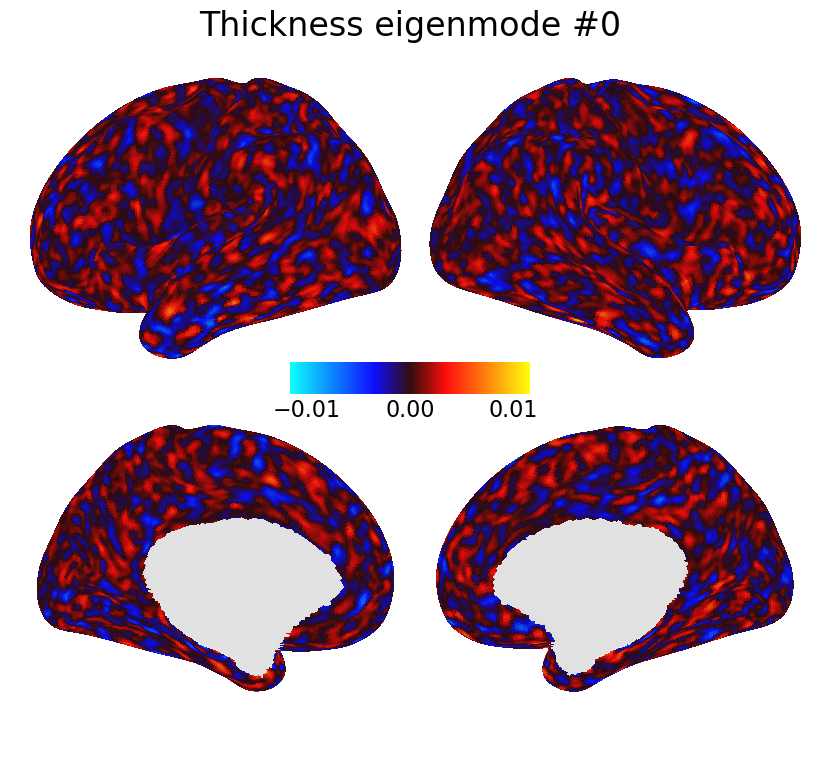

In [175]:
# data
eigenmode_idx = 0
data = thickness_ica.components_[eigenmode_idx]

plot_data_on_brain_surface(
    data,
    title=f"Thickness eigenmode #{eigenmode_idx}",
    symmetric_cbar=True, cmap=mycm_dark,
)


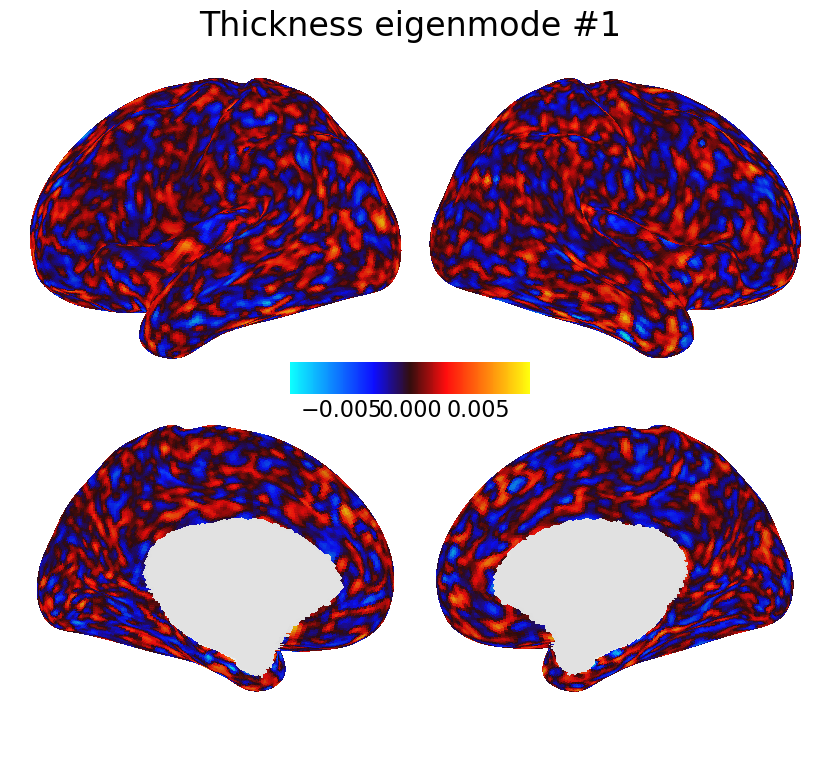

In [176]:
# data
eigenmode_idx = 1
data = thickness_ica.components_[eigenmode_idx]

plot_data_on_brain_surface(
    data,
    title=f"Thickness eigenmode #{eigenmode_idx}",
    symmetric_cbar=True, cmap=mycm_dark,
)


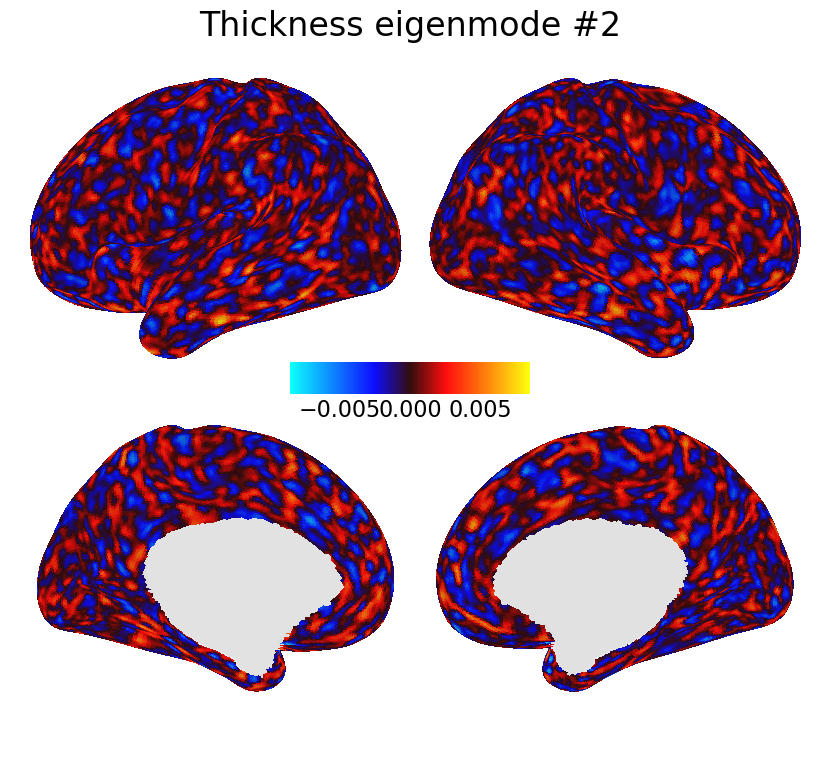

In [177]:
# data
eigenmode_idx = 2
data = thickness_ica.components_[eigenmode_idx]

plot_data_on_brain_surface(
    data,
    title=f"Thickness eigenmode #{eigenmode_idx}",
    symmetric_cbar=True, cmap=mycm_dark,
)


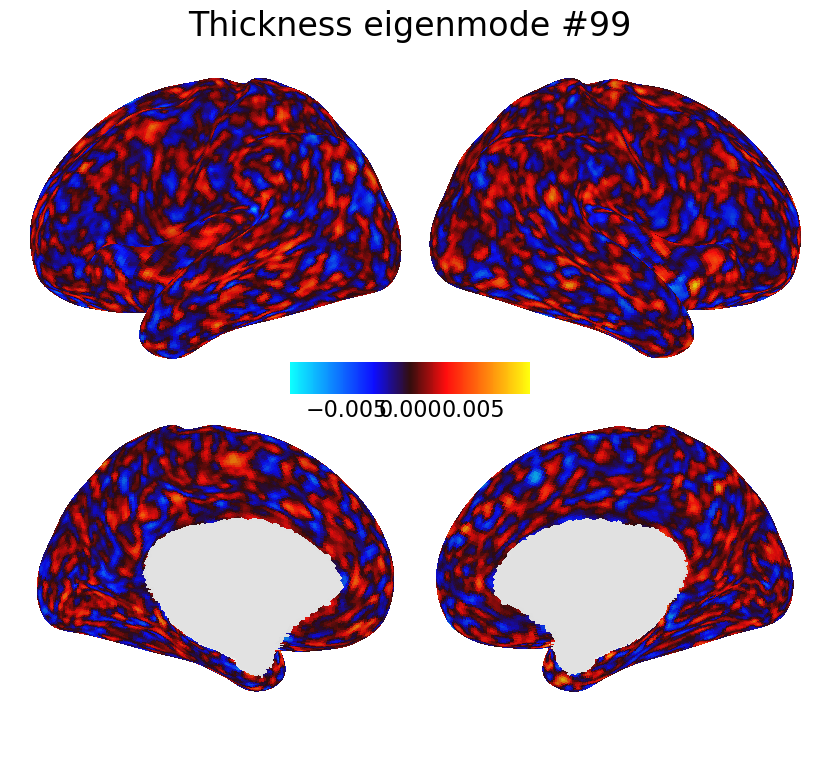

In [178]:
# data
eigenmode_idx = 99
data = thickness_ica.components_[eigenmode_idx]

plot_data_on_brain_surface(
    data,
    title=f"Thickness eigenmode #{eigenmode_idx}",
    symmetric_cbar=True, cmap=mycm_dark,
)


## Projection of the mean thickness information over the generated kernel

---

Mean thickness can be viewed as a vector with a length of number of vertices $$N_v$$ where all elements have an equal weight of $$\frac{1}{N_v}$$.

Here, we visualize the loading of mean thickness, as well as its energy distribution over eigenmodes:

In [11]:
# define the mean thickness operation
# mean_thickness_vector = np.ones(thickness_ica.components_.shape[1])/thickness_ica.components_.shape[1]
mean_thickness_vector = np.ones(thickness_ica.components_.shape[1])

mean_thickness_vector_encoded = thickness_ica.transform(mean_thickness_vector.reshape(1,-1))


In [12]:
mean_thickness_vector_encoded.shape

(1, 1500)

In [67]:
thickness_ica.inverse_transform(mean_thickness_vector_encoded)[0]

array([1.21084053, 1.02787929, 1.09965419, ..., 1.20174064, 1.16910622,
       1.28921729])

<AxesSubplot: ylabel='Count'>

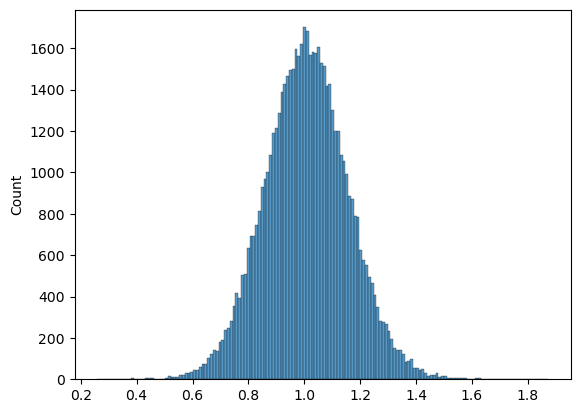

In [72]:
sns.histplot(thickness_ica.inverse_transform(mean_thickness_vector_encoded)[0])

In [68]:
mean_thickness_vector

array([1., 1., 1., ..., 1., 1., 1.])

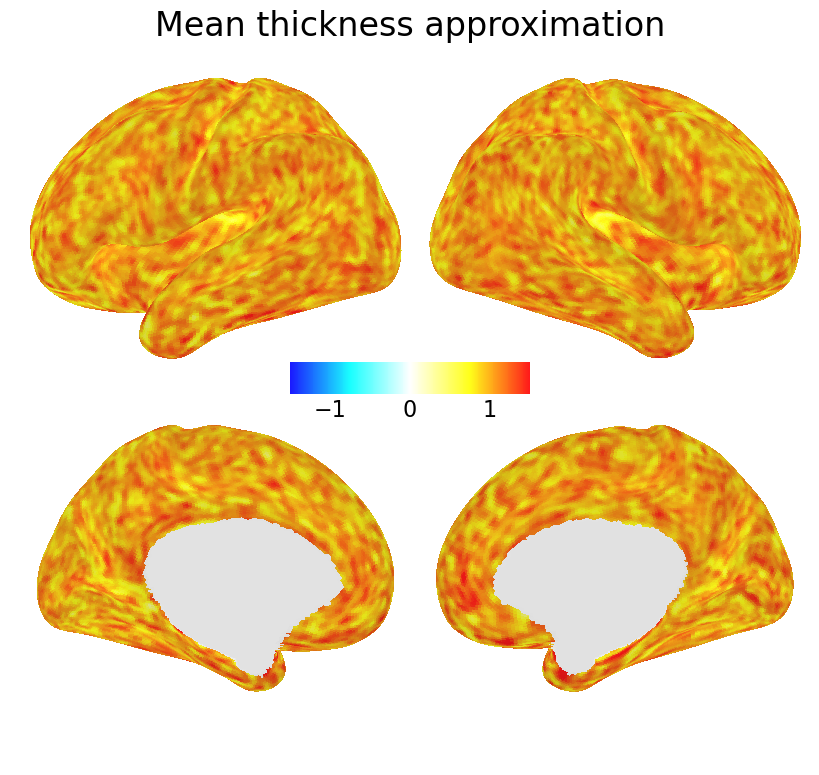

In [163]:
plot_data_on_brain_surface(
    thickness_ica.inverse_transform(mean_thickness_vector_encoded)[0],
    title=f"Mean thickness approximation",
    symmetric_cbar=True, vmax=1.5, vmin=0.,
)


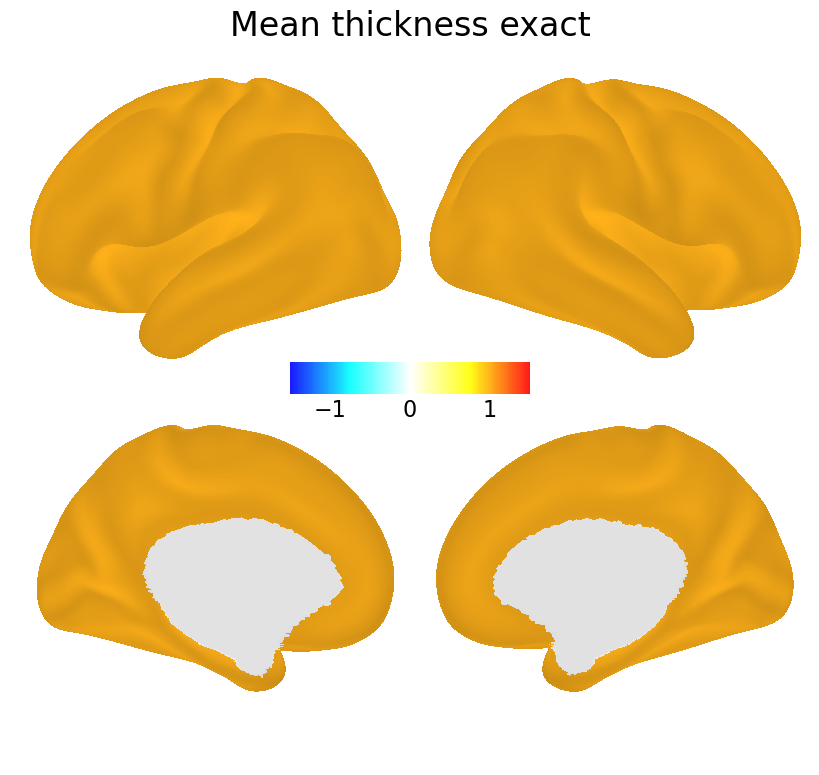

In [164]:
plot_data_on_brain_surface(
    mean_thickness_vector,
    title=f"Mean thickness exact",
    symmetric_cbar=True, vmax=1.5, vmin=0.,
)


In my opinion the performance of this ICA kernel (with 1500 components) is fairly limited at reconstruction.

In [19]:
from sklearn import metrics
mae = metrics.mean_absolute_error(mean_thickness_vector, thickness_ica.inverse_transform(mean_thickness_vector_encoded)[0])
print(f'Mean absolute error of approximation: {mae}')


Mean absolute error of approximation: 0.11898411125220036
